<a href="https://colab.research.google.com/github/LucianoPereiraValenzuela/Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements/blob/main/Codes/vqe-molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating Molecules using VQE

In this tutorial, we introduce the Variational Quantum Eigensolver (VQE), motivate its use, explain the necessary theory, and demonstrate its implementation in finding the ground state energy of molecules.

## Contents
1. [Introduction](#introduction)
2. [The Variational Method of Quantum Mechanics](#varmethod)
    1. [Mathematical Background](#backgroundmath)
    2. [Bounding the Ground State](#groundstate)
3. [The Variational Quantum Eigensolver](#vqe)
    1. [Variational Forms](#varforms)
    2. [Simple Variational Forms](#simplevarform)
    3. [Parameter Optimization](#optimization)
    4. [Example with a Single Qubit Variational Form](#example)
    5. [Structure of Common Variational Forms](#commonvarforms)
4. [VQE Implementation in Qiskit](#implementation)
    1. [Running VQE on a Statevector Simulator](#implementationstatevec)
    2. [Running VQE on a Noisy Simulator](#implementationnoisy)
5. [Problems](#problems)
6. [References](#references)

## Introduction<a id='introduction'></a>
In many applications it is important to find the minimum eigenvalue of a matrix. For example, in chemistry, the minimum eigenvalue of a Hermitian matrix characterizing the molecule is the ground state energy of that system. In the future, the quantum phase estimation algorithm may be used to find the minimum eigenvalue. However, its implementation on useful problems requires circuit depths exceeding the limits of hardware available in the NISQ era. Thus, in 2014, Peruzzo *et al.* proposed VQE to estimate the ground state energy of a molecule using much shallower circuits [1]. 

Formally stated, given a Hermitian matrix $H$ with an unknown minimum eigenvalue $\lambda_{min}$, associated with the eigenstate $|\psi_{min}\rangle$, VQE provides an estimate $\lambda_{\theta}$ bounding $\lambda_{min}$:

\begin{align*}
    \lambda_{min} \le \lambda_{\theta} \equiv \langle \psi(\theta) |H|\psi(\theta) \rangle
\end{align*}  

where $|\psi(\theta)\rangle$ is the eigenstate associated with $\lambda_{\theta}$. By applying a parameterized circuit, represented by $U(\theta)$, to some arbitrary starting state $|\psi\rangle$, the algorithm obtains an estimate $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$ on $|\psi_{min}\rangle$. The estimate is iteratively optimized by a classical controller changing the parameter $\theta$ minimizing the expectation value of $\langle \psi(\theta) |H|\psi(\theta) \rangle$.



## The Variational Method of Quantum Mechanics<a id='varmethod'></a>
### Mathematical Background<a id='backgroundmath'></a>

VQE is an application of the variational method of quantum mechanics. To better understand the variational method, some preliminary mathematical background is provided. An eigenvector, $|\psi_i\rangle$, of a matrix $A$ is invariant under transformation by $A$ up to a scalar multiplicative constant (the eigenvalue $\lambda_i$). That is,

\begin{align*}
    A |\psi_i\rangle = \lambda_i |\psi_i\rangle
\end{align*}

Furthermore, a matrix $H$ is Hermitian when it is equal to its own conjugate transpose.

\begin{align*}
    H = H^{\dagger}
\end{align*}

The spectral theorem states that the eigenvalues of a Hermitian matrix must be real. Thus, any eigenvalue of $H$ has the property that $\lambda_i = \lambda_i^*$. As any measurable quantity must be real, Hermitian matrices are suitable for describing the Hamiltonians of quantum systems. Moreover, $H$ may be expressed as

\begin{align*}
    H = \sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |
\end{align*}

where each $\lambda_i$ is the eigenvalue corresponding to the eigenvector $|\psi_i\rangle$. Furthermore, the expectation value of the observable $H$ on an arbitrary quantum state $|\psi\rangle$ is given by 

\begin{align}
    \langle H \rangle_{\psi} &\equiv \langle \psi | H | \psi \rangle
\end{align}

Substituting $H$ with its representation as a weighted sum of its eigenvectors,

\begin{align}
    \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle &= \langle \psi | \left(\sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |\right) |\psi\rangle\\
    &= \sum_{i = 1}^{N} \lambda_i \langle \psi | \psi_i\rangle \langle \psi_i | \psi\rangle \\
    &= \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{align}


The last equation demonstrates that the expectation value of an observable on any state can be expressed as a linear combination using the eigenvalues associated with $H$ as the weights. Moreover, each of the weights in the linear combination is greater than or equal to 0, as $| \langle \psi_i | \psi\rangle |^2 \ge 0$ and so it is clear that

\begin{align}
    \lambda_{min} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{align}

The above equation is known as the **variational method** (in some texts it is also known as the variational principle) [2]. It is important to note that this implies that the expectation value of any wave function will always be at least the minimum eigenvalue associated with $H$. Moreover, the expectation value of the eigenstate $|\psi_{min}\rangle$ is given by $\langle \psi_{min}|H|\psi_{min}\rangle = \langle \psi_{min}|\lambda_{min}|\psi_{min}\rangle = \lambda_{min}$. Thus, as expected, $\langle H \rangle_{\psi_{min}}=\lambda_{min}$.

### Bounding the Ground State<a id='groundstate'></a>
When the Hamiltonian of a system is described by the Hermitian matrix $H$ the ground state energy of that system, $E_{gs}$, is the smallest eigenvalue associated with $H$. By arbitrarily selecting a wave function $|\psi \rangle$ (called an *ansatz*) as an initial guess approximating $|\psi_{min}\rangle$, calculating its expectation value, $\langle H \rangle_{\psi}$, and iteratively updating the wave function, arbitrarily tight bounds on the ground state energy of a Hamiltonian may be obtained. 




## The Variational Quantum Eigensolver<a id='vqe'></a>
### Variational Forms<a id='varforms'></a>
A systematic approach to varying the ansatz is required to implement the variational method on a quantum computer. VQE does so through the use of a parameterized circuit with a fixed form. Such a circuit is often called a *variational form*, and its action may be represented by the linear transformation $U(\theta)$. A variational form is applied to a starting state $|\psi\rangle$ (such as the vacuum state $|0\rangle$, or the Hartree Fock state) and generates an output state $U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$. Iterative optimization over $|\psi(\theta)\rangle$ aims to yield an expectation value $\langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{min}$. Ideally, $|\psi(\theta)\rangle$ will be close to $|\psi_{min}\rangle$ (where 'closeness' is characterized by either state fidelity, or Manhattan distance) although in practice, useful bounds on $E_{gs}$ can be obtained even if this is not the case.

Moreover, a fixed variational form with a polynomial number of parameters can only generate transformations to a polynomially sized subspace of all the states in an exponentially sized Hilbert space. Consequently, various variational forms exist. Some, such as Ry and RyRz are heuristically designed, without consideration of the target domain. Others, such as UCCSD, utilize domain specific knowledge to generate close approximations based on the problem's structure. The structure of common variational forms is discussed in greater depth later in this document. 

### Simple Variational Forms<a id='simplevarform'></a>
When constructing a variational form we must balance two opposing goals. Ideally, our $n$ qubit variational form would be able to generate any possible state $|\psi\rangle$ where $|\psi\rangle \in \mathbb{C}^N$ and $N=2^n$. However, we would like the variational form to use as few parameters as possible. Here, we aim to give intuition for the construction of variational forms satisfying our first goal, while disregarding the second goal for the sake of simplicity. 

Consider the case where $n=1$. The U3 gate takes three parameters, $\theta, \phi$ and $\lambda$, and represents the following transformation:

$$
\begin{align}
    U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix}
\end{align}
$$

Up to a global phase, any possible single qubit transformation may be implemented by appropriately setting these parameters. Consequently, for the single qubit case, a variational form capable of generating any possible state is given by the circuit:

![image1](https://github.com/LucianoPereiraValenzuela/Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements/blob/main/Codes/images/U3_var_form.png?raw=1)


Moreover, this universal 'variational form' only has 3 parameters and thus can be efficiently optimized. It is worth emphasising that the ability to generate an arbitrary state ensures that during the optimization process, the variational form does not limit the set of attainable states over which the expectation value of $H$ can be taken. Ideally, this ensures that the minimum expectation value is limited only by the capabilities of the classical optimizer. 

A less trivial universal variational form may be derived for the 2 qubit case, where two body interactions, and thus entanglement, must be considered to achieve universality. Based on the work presented by *Shende et al.* [3] the following is an example of a universal parameterized 2 qubit circuit:

![image2](https://github.com/LucianoPereiraValenzuela/Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements/blob/main/Codes/images/two_qubit_var_form.png?raw=1)
     
Allow the transformation performed by the above circuit to be represented by $U(\theta)$. When optimized variationally, the expectation value of $H$ is minimized when $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle \approx |\psi_{min}\rangle$. By formulation, $U(\theta)$ may produce a transformation to any possible state, and so this variational form may obtain an arbitrarily tight bound on two qubit ground state energies, only limited by the capabilities of the classical optimizer.

### Parameter Optimization<a id='optimization'></a>
Once an efficiently parameterized variational form has been selected, in accordance with the variational method, its parameters must be optimized to minimize the expectation value of the target Hamiltonian. The parameter optimization process has various challenges. For example, quantum hardware has various types of noise and so objective function evaluation (energy calculation) may not necessarily reflect the true objective function. Additionally, some optimizers perform a number of objective function evaluations dependent on cardinality of the parameter set. An appropriate optimizer should be selected by considering the requirements of an application.

A popular optimization strategy is gradient descent where each parameter is updated in the direction yielding the largest local change in energy. Consequently, the number of evaluations performed depends on the number of optimization parameters present. This allows the algorithm to quickly find a local optimum in the search space. However, this optimization strategy often gets stuck at poor local optima, and is relatively expensive in terms of the number of circuit evaluations performed. While an intuitive optimization strategy, it is not recommended for use in VQE.

An appropriate optimizer for optimizing a noisy objective function is the *Simultaneous Perturbation Stochastic Approximation* optimizer (SPSA). SPSA approximates the gradient of the objective function with only two measurements. It does so by concurrently perturbing all of the parameters in a random fashion, in contrast to gradient descent where each parameter is perturbed independently. When utilizing VQE in either a noisy simulator or on real hardware, SPSA is recommended as the classical optimizer.

When noise is not present in the cost function evaluation (such as when using VQE with a statevector simulator), a wide variety of classical optimizers may be useful. Two such optimizers supported by Qiskit Aqua are the *Sequential Least Squares Programming* optimizer (SLSQP) and the *Constrained Optimization by Linear Approximation* optimizer (COBYLA). It is worth noting that COBYLA only performs one objective function evaluation per optimization iteration (and thus the number of evaluations is independent of the parameter set's cardinality). Therefore, if the objective function is noise-free and minimizing the number of performed evaluations is desirable, it is recommended to try COBYLA. 

### Example with a Single Qubit Variational Form<a id='example'></a>

We will now use the simple single qubit variational form to solve a problem similar to ground state energy estimation. Specifically, we are given a random probability vector $\vec{x}$ and wish to determine a possible parameterization for our single qubit variational form such that it outputs a probability distribution that is close to $\vec{x}$ (where closeness is defined in terms of the Manhattan distance between the two probability vectors).

We first create the random probability vector in python:

In [1]:
!pip install qiskit pylatexenc pyscf qiskit-optimization qiskit-nature

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.3', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.0', 'qiskit-nature': '0.1.2', 'qiskit-finance': None, 'qiskit-optimization': '0.1.0', 'qiskit-machine-learning': None}

In [3]:
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
# We now convert the random vector into a valid probability vector
target_distr /= sum(target_distr)

We subsequently create a function that takes the parameters of our single U3 variational form as arguments and returns the corresponding quantum circuit:

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
	qr = QuantumRegister(1, name="q")
	cr = ClassicalRegister(1, name='c')
	qc = QuantumCircuit(qr, cr)
	qc.u3(params[0], params[1], params[2], qr[0])
	qc.measure(qr, cr[0])
	return qc

Now we specify the objective function which takes as input a list of the variational form's parameters, and returns the cost associated with those parameters:

In [5]:
from qiskit import Aer, transpile, assemble
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def get_probability_distribution(counts):
	output_distr = [v / NUM_SHOTS for v in counts.values()]
	if len(output_distr) == 1:
		output_distr.append(1 - output_distr[0])
	return output_distr

def objective_function(params):
	# Obtain a quantum circuit instance from the paramters
	qc = get_var_form(params)
	# Execute the quantum circuit to obtain the probability distribution associated with the current parameters
	t_qc = transpile(qc, backend)
	qobj = assemble(t_qc, shots=NUM_SHOTS)
	result = backend.run(qobj).result()
	# Obtain the counts for each measured state, and convert those counts into a probability vector
	output_distr = get_probability_distribution(result.get_counts(qc))
	# Calculate the cost as the distance between the output distribution and the target distribution
	cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)])
	return cost

Finally, we create an instance of the COBYLA optimizer, and run the algorithm. Note that the output varies from run to run. Moreover, while close, the obtained distribution might not be exactly the same as the target distribution, however, increasing the number of shots taken will increase the accuracy of the output.

In [6]:
from qiskit.algorithms.optimizers import COBYLA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
t_qc = transpile(qc, backend)
qobj = assemble(t_qc, shots=NUM_SHOTS)
counts = backend.run(qobj).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  


Target Distribution: [0.51357006 0.48642994]
Obtained Distribution: [0.4819, 0.5181]
Output Error (Manhattan Distance): 0.02845988126116089
Parameters Found: [1.60673351 0.94063218 1.34657553]


### Structure of Common Variational Forms<a id='commonvarforms'></a>
As already discussed, it is not possible for a polynomially parameterized variational form to generate a transformation to any state. Variational forms can be grouped into two categories, depending on how they deal with this limitation. The first category of variational forms use domain or application specific knowledge to limit the set of possible output states. The second approach uses a heuristic circuit without prior domain or application specific knowledge. 

The first category of variational forms exploit characteristics of the problem domain to restrict the set of transformations that may be required. For example, when calculating the ground state energy of a molecule, the number of particles in the system is known *a priori*. Therefore, if a starting state with the correct number of particles is used, by limiting the variational form to only producing particle preserving transformations, the number of parameters required to span the new transformation subspace can be greatly reduced. Indeed, by utilizing similar information from Coupled-Cluster theory, the variational form UCCSD can obtain very accurate results for molecular ground state energy estimation when starting from the Hartree Fock state. Another example illustrating the exploitation of domain-specific knowledge follows from considering the set of circuits realizable on real quantum hardware. Extant quantum computers, such as those based on super conducting qubits, have limited qubit connectivity. That is, it is not possible to implement 2-qubit gates on arbitrary qubit pairs (without inserting swap gates). Thus, variational forms have been constructed for specific quantum computer architectures where the circuits are specifically tuned to maximally exploit the natively available connectivity and gates of a given quantum device. Such a variational form was used in 2017 to successfully implement VQE for the estimation of the ground state energies of molecules as large as BeH$_2$ on an IBM quantum computer [4].

In the second approach, gates are layered such that good approximations on a wide range of states may be obtained. Qiskit Aqua supports three such variational forms: RyRz, Ry and SwapRz (we will only discuss the first two). All of these variational forms accept multiple user-specified configurations. Three essential configurations are the number of qubits in the system, the depth setting, and the entanglement setting. A single layer of a variational form specifies a certain pattern of single qubit rotations and CX gates. The depth setting says how many times the variational form should repeat this pattern. By increasing the depth setting, at the cost of increasing the number of parameters that must be optimized, the set of states the variational form can generate increases. Finally, the entanglement setting selects the configuration, and implicitly the number, of CX gates. For example, when the entanglement setting is linear, CX gates are applied to adjacent qubit pairs in order (and thus $n-1$ CX gates are added per layer). When the entanglement setting is full, a CX gate is applied to each qubit pair in each layer. The circuits for RyRz corresponding to `entanglement="full"` and `entanglement="linear"` can be seen by executing the following code snippet:

In [7]:
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
for entanglement in entanglements:
	form = EfficientSU2(num_qubits=4, entanglement=entanglement)
	if entanglement == "linear":
		print("=============Linear Entanglement:=============")
	else:
		print("=============Full Entanglement:=============")
	# We initialize all parameters to 0 for this demonstration
	display(form.draw())

=============Linear Entanglement:=============


┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐             »
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├─────────────»
     ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤┌───────────┐»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[5]) ├┤ X ├─────■───────┤ RY(θ[9]) ├┤ RZ(θ[13]) ├»
     ├──────────┤├──────────┤└───┘   ┌─┴─┐     └──────────┘├───────────┤»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├────────┤ X ├──────────■──────┤ RY(θ[10]) ├»
     ├──────────┤├──────────┤        └───┘        ┌─┴─┐    ├───────────┤»
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├─────────────────────┤ X ├────┤ RY(θ[11]) ├»
     └──────────┘└──────────┘                     └───┘    └───────────┘»
«                  ┌───────────┐┌───────────┐                          »
«q_0: ──────■──────┤ RY(θ[16]) ├┤ RZ(θ[20]) ├───────────────────■──────»
«         ┌─┴─┐    └───────────┘├───────────┤┌───────────┐    ┌─┴─┐    »
«q_1: ────┤ X ├──────────■──────┤ RY(θ[17]) ├┤ RZ(θ[21]) ├────┤ X ├────»
«     ┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐»
«q_2: ┤ RZ(θ[14]) ├────┤ X ├──────────■──────┤ RY(θ[18]) ├┤ RZ(θ[22]) ├»
«     ├───────────┤    └───┘        ┌─┴─┐    ├───────────┤├───────────┤»
«q_3: ┤ RZ(θ[15]) ├─────────────────┤ X ├────┤ RY(θ[19]) ├┤ RZ(θ[23]) ├»
«     └───────────┘                 └───┘    └───────────┘└───────────┘»
«     ┌───────────┐┌───────────┐                          
«q_0: ┤ RY(θ[24]) ├┤ RZ(θ[28]) ├──────────────────────────
«     └───────────┘├───────────┤┌───────────┐             
«q_1: ──────■──────┤ RY(θ[25]) ├┤ RZ(θ[29]) ├─────────────
«         ┌─┴─┐    └───────────┘├───────────┤┌───────────┐
«q_2: ────┤ X ├──────────■──────┤ RY(θ[26]) ├┤ RZ(θ[30]) ├
«         └───┘        ┌─┴─┐    ├───────────┤├───────────┤
«q_3: ─────────────────┤ X ├────┤ RY(θ[27]) ├┤ RZ(θ[31]) ├
«                      └───┘    └───────────┘└───────────┘

=============Full Entanglement:=============


┌──────────┐┌──────────┐               ┌──────────┐┌───────────┐»
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■────■────■──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├»
     ├──────────┤├──────────┤┌─┴─┐  │    │  └──────────┘└───────────┘»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[5]) ├┤ X ├──┼────┼───────■────────────■──────»
     ├──────────┤├──────────┤└───┘┌─┴─┐  │     ┌─┴─┐          │      »
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├─────┤ X ├──┼─────┤ X ├──────────┼──────»
     ├──────────┤├──────────┤     └───┘┌─┴─┐   └───┘        ┌─┴─┐    »
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├──────────┤ X ├────────────────┤ X ├────»
     └──────────┘└──────────┘          └───┘                └───┘    »
«                                                     ┌───────────┐»
«q_0: ───────────────────────────────■────────■────■──┤ RY(θ[16]) ├»
«     ┌──────────┐┌───────────┐    ┌─┴─┐      │    │  └───────────┘»
«q_1: ┤ RY(θ[9]) ├┤ RZ(θ[13]) ├────┤ X ├──────┼────┼────────■──────»
«     └──────────┘├───────────┤┌───┴───┴───┐┌─┴─┐  │      ┌─┴─┐    »
«q_2: ─────■──────┤ RY(θ[10]) ├┤ RZ(θ[14]) ├┤ X ├──┼──────┤ X ├────»
«        ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐    └───┘    »
«q_3: ───┤ X ├────┤ RY(θ[11]) ├┤ RZ(θ[15]) ├─────┤ X ├─────────────»
«        └───┘    └───────────┘└───────────┘     └───┘             »
«     ┌───────────┐                                                 »
«q_0: ┤ RZ(θ[20]) ├────────────────────────────────■────────■────■──»
«     └───────────┘┌───────────┐┌───────────┐    ┌─┴─┐      │    │  »
«q_1: ──────■──────┤ RY(θ[17]) ├┤ RZ(θ[21]) ├────┤ X ├──────┼────┼──»
«           │      └───────────┘├───────────┤┌───┴───┴───┐┌─┴─┐  │  »
«q_2: ──────┼────────────■──────┤ RY(θ[18]) ├┤ RZ(θ[22]) ├┤ X ├──┼──»
«         ┌─┴─┐        ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐»
«q_3: ────┤ X ├────────┤ X ├────┤ RY(θ[19]) ├┤ RZ(θ[23]) ├─────┤ X ├»
«         └───┘        └───┘    └───────────┘└───────────┘     └───┘»
«     ┌───────────┐┌───────────┐                                       
«q_0: ┤ RY(θ[24]) ├┤ RZ(θ[28]) ├───────────────────────────────────────
«     └───────────┘└───────────┘┌───────────┐┌───────────┐             
«q_1: ──────■────────────■──────┤ RY(θ[25]) ├┤ RZ(θ[29]) ├─────────────
«         ┌─┴─┐          │      └───────────┘├───────────┤┌───────────┐
«q_2: ────┤ X ├──────────┼────────────■──────┤ RY(θ[26]) ├┤ RZ(θ[30]) ├
«         └───┘        ┌─┴─┐        ┌─┴─┐    ├───────────┤├───────────┤
«q_3: ─────────────────┤ X ├────────┤ X ├────┤ RY(θ[27]) ├┤ RZ(θ[31]) ├
«                      └───┘        └───┘    └───────────┘└───────────┘

Assume the depth setting is set to $d$. Then, RyRz has $2n\times (d+1)$ parameters and Ry (not shown) has $n\times (d+1)$ parameters.

## VQE Implementation in Qiskit<a id='implementation'></a>
This section illustrates an implementation of VQE using the programmatic approach. Qiskit Aqua also enables a declarative implementation, however, it reveals less information about the underlying algorithm. This code, specifically the preparation of qubit operators, is based on the code found in the Qiskit Tutorials repository (and as of July 2019, may be found at: https://github.com/Qiskit/qiskit-tutorials ).

The following libraries must first be imported. 


In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

### Running VQE on a Statevector Simulator<a id='implementationstatevec'></a>
We demonstrate the calculation of the ground state energy for LiH at various interatomic distances. A driver for the molecule must be created at each such distance. Note that in this experiment, to reduce the number of qubits used, we freeze the core and remove two unoccupied orbitals. First, we define a function that takes an interatomic distance and returns the appropriate qubit operator, $H$, as well as some other information about the operator.

In [9]:
def get_qubit_op(dist):
	driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM,
						 charge=0, spin=0, basis='sto3g')
	molecule = driver.run()
	freeze_list = [0]
	remove_list = [-3, -2]
	repulsion_energy = molecule.nuclear_repulsion_energy
	num_particles = molecule.num_alpha + molecule.num_beta
	num_spin_orbitals = molecule.num_orbitals * 2
	remove_list = [x % molecule.num_orbitals for x in remove_list]
	freeze_list = [x % molecule.num_orbitals for x in freeze_list]
	remove_list = [x - len(freeze_list) for x in remove_list]
	remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
	freeze_list += [x + molecule.num_orbitals for x in freeze_list]
	ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
	ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
	num_spin_orbitals -= len(freeze_list)
	num_particles -= len(freeze_list)
	ferOp = ferOp.fermion_mode_elimination(remove_list)
	num_spin_orbitals -= len(remove_list)
	qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
	qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
	shift = energy_shift + repulsion_energy
	return qubitOp, num_particles, num_spin_orbitals, shift

In [10]:
test = get_qubit_op(5)

In [11]:
# print(len(test[0].print_details()))
print(test[0].print_details())

IIII	(-0.24895049579243647+0j)
IIIZ	(-0.10355107795320165+0j)
IIZX	(0.03199498432512055+0j)
IIIX	(-0.03199498432512055+0j)
IIXX	(-8.037317235985459e-05+0j)
IIYY	(8.037317235985459e-05+0j)
IIZZ	(-0.10495431256365699+0j)
IIXZ	(-0.007763818717513042+0j)
IIXI	(-0.007763818717513042+0j)
IIZI	(0.18494127529584625+0j)
IZII	(0.10355107795320162+0j)
ZXII	(-0.031994984325120594+0j)
IXII	(-0.031994984325120594+0j)
XXII	(-8.037317235985372e-05+0j)
YYII	(8.037317235985372e-05+0j)
ZZII	(-0.10495431256365696+0j)
XZII	(0.007763818717513045+0j)
XIII	(-0.007763818717513045+0j)
ZIII	(-0.1849412752958463+0j)
IZIZ	(-0.08610127549155787+0j)
IZZX	(-0.03579168847775564+0j)
IZIX	(0.03579168847775564+0j)
IZXX	(-0.0018516651980102718+0j)
IZYY	(0.0018516651980102718+0j)
IXIZ	(-0.035791688477755636+0j)
ZXIZ	(-0.035791688477755636+0j)
IXZX	(-0.05240325622937928+0j)
ZXZX	(-0.05240325622937928+0j)
IXIX	(0.05240325622937928+0j)
ZXIX	(0.05240325622937928+0j)
IXXX	(-0.0015594266359363455+0j)
ZXXX	(-0.0015594266359363455

First, the exact ground state energy is calculated using the qubit operator and a classical exact eigensolver. Subsequently, the initial state $|\psi\rangle$ is created, which the VQE instance uses to produce the final ansatz $\min_{\theta}(|\psi(\theta)\rangle)$. The exact result and the VQE result at each interatomic distance is stored. Observe that the result given by `vqe.run(backend)['energy'] + shift` is equivalent the quantity $\min_{\theta}\left(\langle \psi(\theta)|H|\psi(\theta)\rangle\right)$, where the minimum is not necessarily the global minimum. 

When initializing the VQE instance with `VQE(qubitOp, var_form, optimizer, 'matrix')` the expectation value of $H$ on $|\psi(\theta)\rangle$ is directly calculated through matrix multiplication. However, when using an actual quantum device, or a true simulator such as the `qasm_simulator` with `VQE(qubitOp, var_form, optimizer, 'paulis')` the calculation of the expectation value is more complicated. A Hamiltonian may be represented as a sum of a Pauli strings, with each Pauli term acting on a qubit as specified by the mapping being used. Each Pauli string has a corresponding circuit appended to the circuit corresponding to $|\psi(\theta)\rangle$. Subsequently, each of these circuits is executed, and all of the results are used to determine the expectation value of $H$ on $|\psi(\theta)\rangle$. In the following example, we initialize the VQE instance with `matrix` mode, and so the expectation value is directly calculated through matrix multiplication. 

Note that the following code snippet may take a few minutes to run to completion. 

In [12]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
	qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
	result = NumPyEigensolver(qubitOp).run()
	exact_energies.append(np.real(result.eigenvalues) + shift)
	initial_state = HartreeFock(
		num_spin_orbitals,
		num_particles,
		qubit_mapping='parity'
		)
	var_form = UCCSD(
		num_orbitals=num_spin_orbitals,
		num_particles=num_particles,
		initial_state=initial_state,
		qubit_mapping='parity'
		)
	vqe = VQE(qubitOp, var_form, optimizer)
	vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
	vqe_energies.append(vqe_result)
	print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.039710214877602 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.313344301244756 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500921095711126 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.630976915080151 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.7208107948795694 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.78224065533281 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823597493135857 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.850696622411123 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867561602386951 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.876999876408476 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.881014174012377 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881070663240508 Exact Ene

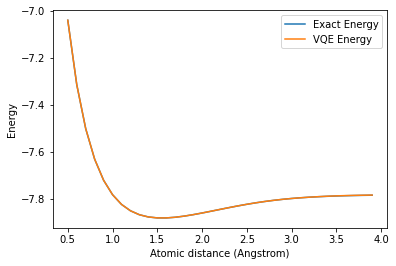

In [13]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

Note that the VQE results are very close to the exact results, and so the exact energy curve is hidden by the VQE curve.

### Running VQE on a Noisy Simulator<a id='implementationnoisy'></a>

Here, we calculate the ground state energy for H$_2$ using a noisy simulator and error mitigation. 

First, we prepare the qubit operator representing the molecule's Hamiltonian:

In [ ]:
driver = PySCFDriver(atom='H .0 .0 -0.3625; H .0 .0 0.3625', unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()
num_particles = molecule.num_alpha + molecule.num_beta
qubitOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals).mapping(map_type='parity')
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)

Now, we load a device coupling map and noise model from the IBMQ provider and create a quantum instance, enabling error mitigation:

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend,
								   shots=8192,
								   noise_model=noise_model,
								   coupling_map=coupling_map,
								   measurement_error_mitigation_cls=CompleteMeasFitter,
								   cals_matrix_refresh_period=30)

/home/david/anaconda3/envs/hackathon/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
ibmqfactory.load_account:WARNING:1970-01-01 17:34:53,414: Credentials are already in use. The existing account in the session will be replaced.
/home/david/anaconda3/envs/hackathon/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/david/anaconda3/envs/hackathon/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/david/anaconda3/envs/hackathon/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL v

Finally, we must configure the optimizer, the variational form, and the VQE instance. As the effects of noise increase as the number of two qubit gates circuit depth increase, we use a heuristic variational form (RYRZ) rather than UCCSD as RYRZ has a much shallower circuit than UCCSD and uses substantially fewer two qubit gates.

The following code may take a few minutes to run to completion.

In [ ]:
exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
optimizer = SPSA(maxiter=100)
var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue'] + molecule.nuclear_repulsion_energy)
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: -1.1150545129847238


In [ ]:
print(qubitOp.print_details())

II	(-1.0501604336972703+0j)
IZ	(0.4042146605457886+0j)
ZI	(-0.4042146605457887+0j)
ZZ	(-0.011346884397300416+0j)
XX	(0.18037524720542222+0j)



In [ ]:
circuit = QuantumCircuit(2)
# circuit.h([0,1])
# circuit.x([0])
temp = qubitOp.construct_evaluation_circuit(wave_function=circuit, statevector_mode=False)
for x in temp:
	print(x.decompose())

      ░ ┌─┐   
q_0: ─░─┤M├───
      ░ └╥┘┌─┐
q_1: ─░──╫─┤M├
      ░  ║ └╥┘
c: 2/════╩══╩═
         0  1 
      ░ ┌─┐   
q_0: ─░─┤M├───
      ░ └╥┘┌─┐
q_1: ─░──╫─┤M├
      ░  ║ └╥┘
c: 2/════╩══╩═
         0  1 
      ░ ┌─┐   
q_0: ─░─┤M├───
      ░ └╥┘┌─┐
q_1: ─░──╫─┤M├
      ░  ║ └╥┘
c: 2/════╩══╩═
         0  1 
      ░ ┌─┐   
q_0: ─░─┤M├───
      ░ └╥┘┌─┐
q_1: ─░──╫─┤M├
      ░  ║ └╥┘
c: 2/════╩══╩═
         0  1 
     ┌───┐ ░ ┌─┐   
q_0: ┤ H ├─░─┤M├───
     ├───┤ ░ └╥┘┌─┐
q_1: ┤ H ├─░──╫─┤M├
     └───┘ ░  ║ └╥┘
c: 2/═════════╩══╩═
              0  1 


When noise mitigation is enabled, even though the result does not fall within chemical accuracy (defined as being within 0.0016 Hartree of the exact result), it is fairly close to the exact solution. 

## Problems<a id='problems'></a>
1. You are given a Hamiltonian $H$ with the promise that its ground state is close to a maximally entangled $n$ qubit state. Explain which variational form (or forms) is likely to efficiently and accurately learn the ground state energy of $H$. You may also answer by creating your own variational form, and explaining why it is appropriate for use with this Hamiltonian. 
2. Calculate the number of circuit evaluations performed per optimization iteration, when using the COBYLA optimizer, the `qasm_simulator` with 1000 shots, and a Hamiltonian with 60 Pauli strings.
3. Use VQE to estimate the ground state energy of BeH$_2$ with an interatomic distance of $1.3$Å. You may re-use the function `get_qubit_op(dist)` by replacing `atom="Li .0 .0 .0; H .0 .0 " + str(dist)` with `atom="Be .0 .0 .0; H .0 .0 -" + str(dist) + "; H .0 .0 " + str(dist)` and invoking the function with `get_qubit_op(1.3)`. Note that removing the unoccupied orbitals does not preserve chemical precision for this molecule. However, to get the number of qubits  required down to 6 (and thereby allowing efficient simulation on most laptops), the loss of precision is acceptable. While beyond the scope of this exercise, the interested reader may use qubit tapering operations to reduce the number of required qubits to 7, without losing any chemical precision.

## References<a id='references'></a>
1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." *Nature communications* 5 (2014): 4213.
2. Griffiths, David J., and Darrell F. Schroeter. Introduction to quantum mechanics. *Cambridge University Press*, 2018.
3. Shende, Vivek V., Igor L. Markov, and Stephen S. Bullock. "Minimal universal two-qubit cnot-based circuits." arXiv preprint quant-ph/0308033 (2003).
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242.

In [ ]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.2', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.4', 'qiskit-nature': '0.1.1', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}